**Content Disclaimer**: This dataset contains real title posts scraped from the r/depression subreddit, and some of the titles contain language that is not safe for work, crude, or offensive. The full dataset is available as `depression.csv`, `preprocessed_thoughts.csv`, `thoughts.csv`, and `token_df.csv`. Unfortunately, I did not provide a sanitized version of my dataset because the words contained were important for the analysis and understanding of the model. Please note that the model, the dataset, and the techniques used are not perfect. If you have any concerns about working with this dataset, looking at my analysis, or the topic in general, you can skip my content overall or click [here](http://iamsorry.com/).

### Table of Contents

*If links don't work then it this at least shows the order of the notebook*

- [Loading Pickles](https://git.generalassemb.ly/laternader/project_3/blob/master/deliverables/4-Model-Comparisons.ipynb#Load-the-Pickled-Models)
- [Scores](https://git.generalassemb.ly/laternader/project_3/blob/master/deliverables/4-Model-Comparisons.ipynb#Let's-look-at-the-scores-from-each)
- [Parameters](https://git.generalassemb.ly/laternader/project_3/blob/master/deliverables/4-Model-Comparisons.ipynb#Let's-look-at-the-parameters)
- [Train/Test Scores](https://git.generalassemb.ly/laternader/project_3/blob/master/deliverables/4-Model-Comparisons.ipynb#The-train-and-test-scores-for-all-the-models)
- [Confusion Matrices](https://git.generalassemb.ly/laternader/project_3/blob/master/deliverables/4-Model-Comparisons.ipynb#Confusion-Matrices)
- Post EDA Work
    - [Feature Importance](https://git.generalassemb.ly/laternader/project_3/blob/master/deliverables/4-Model-Comparisons.ipynb#Feature-Importance)
    - [Good Indicators](https://git.generalassemb.ly/laternader/project_3/blob/master/deliverables/4-Model-Comparisons.ipynb#Which-words-are-good-indicators-outside-of-the-stopwords?)
    - [Sentiment Analysis](https://git.generalassemb.ly/laternader/project_3/blob/master/deliverables/4-Model-Comparisons.ipynb#How-sad-are-they?)
    - [F1 Scores](https://git.generalassemb.ly/laternader/project_3/blob/master/deliverables/4-Model-Comparisons.ipynb#F1-Scores)
- [Conclusion](https://git.generalassemb.ly/laternader/project_3/blob/master/deliverables/4-Model-Comparisons.ipynb#Final-Conclusions)

# Model Comparisons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Load the Pickled Models

---
To keep things organized, I have three models imported. In these models, this is what they stand for.

+ `best` - I considered this the best model because the difference between the train and test scores was less than 2 and in the low-mid 90s in accuracy,
+ `forest` - The best forest model I could produce where the test score wasn't as far as it was from the train score and where the it was optimized for sensitivity.
+ `another` - This model had a reasonable and better train and test score than all of my other models. I didn't consider it the best due to the gap between the train and test score was larger than what I considered the best. I think there is some over fit as well.

In [2]:
best = pickle.load(open('./assets/best_model.pkl','rb'))
forest = pickle.load(open('./assets/forest_model.pkl','rb'))
another = pickle.load(open('./assets/another_model.pkl','rb'))

## Let's look at the scores from each model

---
Looking at the best score, I confirmed my decision on why I selected the specific model as my "best". The mean of the cross val scores. These were all pretty much on 5 folds, so the fact that the numbers are the same shows there is some high variance in the `another` model.

In [41]:
best.best_score_

0.9138805970149255

In [3]:
forest.best_score_

0.9120149253731343

In [4]:
another.best_score_

0.9193283582089551

## Let's look at the parameters

---
One thing to notice is that what I considered my best model was using a LogisticRegression model. What I considered second best was also a LogisticRegression model. However the parameters differed and the data they took in differed. For the `best` model, I used data that came from me "PorterStemming" the post titles and then feeding them through the TfidVectorizer transformer while `another` used the original title post and CountVectorized the titles. This also led to a difference in the amount of max features (the top max_features ordered by term frequency across the corpus), regularization strength and minimum data frequency (the word has to appear a minimum).

In my `forest` model, it used almost all defaults except where max_features was set to 'log2' in terms of size and the n_estimators was high at 150. I am sure that if given more time (*and sanity*) I could go back and increase it and maybe the overfitting could have been reduced.

The one common thing that all my models shared was not using the stop words in any of the best models. I found that peculiar because I would assume that those words would be not as important in determing if one post was a part of one subreddit or not. However looking at the n_gram_range, I don't think I should be surprised that possibly pairs or triplets might have played a larger role in classifying a post.

In [7]:
best.best_params_

{'model__C': 1,
 'model__penalty': 'l2',
 'trans__max_df': 0.85,
 'trans__max_features': 3000,
 'trans__min_df': 5,
 'trans__ngram_range': (1, 3),
 'trans__stop_words': None}

In [6]:
best.best_estimator_

Pipeline(steps=[('trans',
                 TfidfVectorizer(max_df=0.85, max_features=3000, min_df=5,
                                 ngram_range=(1, 3))),
                ('model', LogisticRegression(C=1))])

In [8]:
forest.best_params_

{'model__max_depth': None,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__n_estimators': 150,
 'trans__ngram_range': (1, 1),
 'trans__stop_words': None}

In [9]:
forest.best_estimator_

Pipeline(steps=[('trans', TfidfVectorizer()),
                ('model',
                 RandomForestClassifier(max_features='log2',
                                        n_estimators=150))])

In [10]:
another.best_params_

{'model__C': 0.95,
 'model__penalty': 'l2',
 'trans__max_df': 0.85,
 'trans__max_features': 6000,
 'trans__min_df': 3,
 'trans__ngram_range': (1, 3),
 'trans__stop_words': None}

In [11]:
another.best_estimator_

Pipeline(steps=[('trans',
                 CountVectorizer(max_df=0.85, max_features=6000, min_df=3,
                                 ngram_range=(1, 3))),
                ('model', LogisticRegression(C=0.95))])

## The train and test scores for all the models

---
As I have state previously, the `best` model was chose as the best one because of the difference between train and test scores. Granted since the train scores tend to always be better than test scores, I wanted a model that minimized that as much as possible. So the `best` model fit the bill. 

And with the `best_score_` being the consistent through all three of these models, I have justification that accounting for overfit is a good way to select my model. This was also why I considered the `forest` model to be worse because although it was a ~.99 accuracy, that didn't account for the fact that there was clear overfitting.

In `another`, the train and test scores were very high, very accurate (*for what it's worth*). However, there was still a considerable gap between the two which showed that the model couldn't be generalized. If you look at the upcoming confusion matrices, it becomes apparent.

In [13]:
best_train = pickle.load(open('./assets/best_train_score.pkl','rb'))
best_test = pickle.load(open('./assets/best_test_score.pkl','rb'))
forest_train = pickle.load(open('./assets/forest_train_score.pkl','rb'))
forest_test = pickle.load(open('./assets/forest_test_score.pkl','rb'))
another_train = pickle.load(open('./assets/another_train_score.pkl','rb'))
another_test = pickle.load(open('./assets/another_test_score.pkl','rb'))

In [22]:
print('Best Train Score:', best_train)
print('Best Test Score:', best_test)
print()
print('Forest Train Score:', forest_train)
print('Forest Test Score:', forest_test)
print()
print('Another Train Score:', another_train)
print('Another Test Score:', another_test)

Best Train Score: 0.9373880597014925
Best Test Score: 0.9216666666666666

Forest Train Score: 0.9982089552238806
Forest Test Score: 0.9168181818181819

Another Train Score: 0.9658955223880596
Another Test Score: 0.9316666666666666


## Confusion Matrices

---
One of the main reasons for `best` model to be considered my best model was also due to the fact that the specificity and sensitivity were consistent without optimization. I felt confident that this model could be used in other subreddits, but I will not delve into that too deeply.

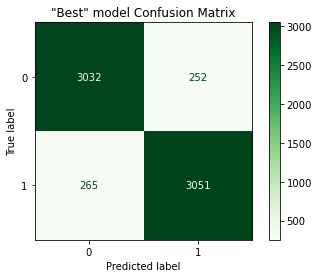

In [241]:
pickle.load(open('./assets/best_confusionmatrix.pkl','rb'))
plt.title('"Best" model Confusion Matrix')

# plt.savefig('imgs/bestconf.png');

In [41]:
# Calculate specificity and sensitivity by hand since I didn't know how to pickle them properly
spec1 = 3032 / (3032 + 252)
sens1 = 3051 / (3051 + 265)
print('Best Specificity:',spec1, 'Best Sensitivity:', sens1)

Best Specificity: 0.9232643118148599 Best Sensitivity: 0.9200844390832328


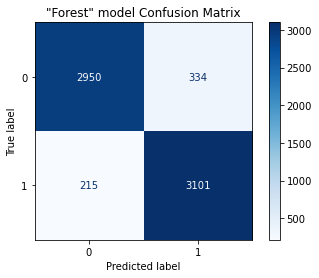

In [242]:
pickle.load(open('./assets/forest_confusionmatrix.pkl','rb'))
plt.title('"Forest" model Confusion Matrix');

# plt.savefig('imgs/forestconf.png')

The forest model seemed to optimize for sensitivity which is something to note in random forest models.

In [42]:
spec2 = 2950 / (2950 + 334)
sens2 = 3101 / (3101 + 215)
print('Forest Specificity:',spec2, 'Forest Sensitivity:', sens2)

Forest Specificity: 0.8982947624847747 Forest Sensitivity: 0.9351628468033776


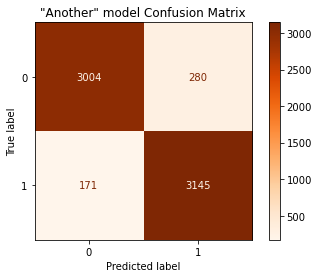

In [243]:
pickle.load(open('./assets/another_confusionmatrix.pkl','rb'))
plt.title('"Another" model Confusion Matrix');

# plt.savefig('imgs/anotherconf.png')

Sensitivity was also optimized for in the `another` model without having to decrease the sensitivity as much. In comparison to `best` model, I thought this would be a good thing to point out because I was able to decrease the amount of false negatives. So if my model was used to try and figure out if someone had depresion (*in an extreme case where my model is the only thing that can determine that*) through their reddit post, at the very least we are reducing the amount of times we make mistakes. Ideally, we want false negatives to be 0, but to get my sensitivity this high was a good thing to notice.

In [43]:
spec3 = 3004 / (3004 + 280)
sens3 = 3145 / (3145 + 171)
print('Another Specificity:',spec3, 'Another Sensitivity:', sens3)

Another Specificity: 0.9147381242387332 Another Sensitivity: 0.9484318455971049


# Post-EDA Work

## Feature Importance

---
We will see what were the top features from each model and the weight they brought in indicating whether or not a post was from the "depression" or "shower thoughts" subreddit.

How I was able to interpret the coefficients on my logistic regression was from [here](https://www.displayr.com/how-to-interpret-logistic-regression-coefficients/).

In [110]:
# First create the DataFrame
best_df = pd.DataFrame(best.best_estimator_.named_steps.model.coef_, 
             columns = best.best_estimator_.named_steps.trans.get_feature_names(),
             ).T
# Reset the index
best_df.reset_index(inplace=True)
# Rename the column names
best_df.rename(columns={'index':'word(s)', 
                        0: 'coefficient'}, inplace=True)
# Sort Values 
ordered_best = best_df.sort_values('coefficient',ascending=False)
# Add Exponentiated Coefficients
ordered_best['exp_coef'] = np.exp(ordered_best['coefficient'])
# Look at the top and bottom
ordered_best.head(25)

,word(s),coefficient,exp_coef
592,depress,9.040511,8438.084964
1603,my,5.688897,295.567368
1517,me,5.258693,192.229999
819,feel,5.007686,149.558261
2254,suicid,3.840616,46.554127
1066,help,3.816397,45.440198
1630,myself,3.583370,35.994655
165,anyon,2.918018,18.504566
1233,is it,2.739656,15.481652
827,feel like,2.697899,14.848507


In [112]:
ordered_best.tail(25)

,word(s),coefficient,exp_coef
1592,movi,-2.418814,0.089027
186,are just,-2.447682,0.086494
439,car,-2.467881,0.084764
2282,technic,-2.485573,0.083278
2743,water,-2.501101,0.081995
999,ha,-2.503127,0.081829
2929,you can,-2.507241,0.081493
1506,mask,-2.534510,0.079301
1115,human,-2.545687,0.078419
2895,would,-2.569308,0.076589


In [106]:
# Forest model
forest_df = pd.DataFrame(forest.best_estimator_.named_steps.model.feature_importances_, 
             index = forest.best_estimator_.named_steps.trans.get_feature_names(),
             )
# Reset Index
forest_df.reset_index(inplace=True)
# Rename columns
forest_df.rename(columns={'index':'word(s)',
                         0:'feature_importance'}, inplace=True)
# Sort Values
forest_df = forest_df.sort_values('feature_importance',ascending=False)
# View top 25 then bottom 25
forest_df.head(25)

,word(s),feature_importance
3990,is,0.025010
7480,the,0.024528
632,are,0.020807
4955,my,0.014939
8488,you,0.014808
2107,depress,0.014066
3734,if,0.012990
7606,to,0.010490
8226,we,0.010063
5206,of,0.009416


In [107]:
forest_df.tail(25)

,word(s),feature_importance
6375,romantic,2.018436e-09
2292,divid,1.409999e-09
5383,painless,1.467162e-10
4628,mcu,0.000000e+00
2271,disproven,0.000000e+00
3350,gringo,0.000000e+00
1185,budapest,0.000000e+00
3639,host,0.000000e+00
6033,radiu,0.000000e+00
4426,locker,0.000000e+00


In [111]:
# First create the DataFrame
another_df = pd.DataFrame(another.best_estimator_.named_steps.model.coef_, 
             columns = another.best_estimator_.named_steps.trans.get_feature_names(),
             ).T
# Reset the index
another_df.reset_index(inplace=True)
# Rename the column names
another_df.rename(columns={'index':'word(s)', 
                        0: 'coefficient'}, inplace=True)
# Sort Values 
another_df = another_df.sort_values('coefficient',ascending=False)
# Add Exponentiated Coefficients
another_df['exp_coef'] = np.exp(another_df['coefficient'])
# Look at the top and bottom
another_df.head(25)

,word(s),coefficient,exp_coef
1144,depress,4.355729,77.923585
4463,suicid,2.613901,13.652203
3054,mental,2.221862,9.224495
2078,help,2.024210,7.570128
2432,is it,1.966582,7.146206
2490,is there,1.848365,6.349430
3003,me,1.832939,6.252236
109,advic,1.816785,6.152050
5715,wish,1.752979,5.771771
5398,vent,1.748445,5.745664


In [113]:
another_df.tail(25)

,word(s),coefficient,exp_coef
1815,gay,-1.458247,0.232644
865,cannib,-1.464206,0.231262
811,call,-1.472269,0.229404
3052,men,-1.501767,0.222736
1963,hair,-1.508528,0.221235
4183,shark,-1.513356,0.220170
3164,must,-1.530992,0.216321
1018,cooki,-1.597107,0.202481
871,car,-1.648539,0.192331
5495,we,-1.651022,0.191854


This confirms that when it came to figuring out if a post was from the "depression" subreddit, it was clearly obvious that many variants of the word ***depress*** would be a top consideration for that. What was surprising was in the `another` model the combination of <font color = 'red'>"*fuck my life*"</font> and <font color = 'red'>"*fuck my*"</font> were in the bottom in terms of coefficient. This meant that these words were not from the "depression" subreddit. 

## Which words are good indicators outside of the stopwords?

In [114]:
# Import stopwords
from nltk.corpus import stopwords

stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

I made a formula that could help me filter out the stopword so I can focus on words that have more meaning in determining whether or not a post is from the "depression" subreddit or the "shower thoughts" subreddit.

In [119]:
def check_word(word):
    return word in stopwords.words('english')

In [125]:
ordered_best[ordered_best['word(s)'].map(check_word)==False].head(25)

,word(s),coefficient,exp_coef
592,depress,9.040511,8438.084964
819,feel,5.007686,149.558261
2254,suicid,3.840616,46.554127
1066,help,3.816397,45.440198
165,anyon,2.918018,18.504566
1233,is it,2.739656,15.481652
827,feel like,2.697899,14.848507
2725,want to,2.660107,14.297823
2856,wish,2.628148,13.848098
904,friend,2.547431,12.774250


In [126]:
forest_df[forest_df['word(s)'].map(check_word)==False].head(25)

,word(s),feature_importance
2107,depress,0.014066
2859,feel,0.009279
5512,peopl,0.005289
5852,probabl,0.005151
4384,like,0.004702
8398,would,0.004670
4369,life,0.004392
3522,help,0.004317
8187,want,0.004280
7508,thi,0.004213


In [127]:
another_df[another_df['word(s)'].map(check_word)==False].head(25)

,word(s),coefficient,exp_coef
1144,depress,4.355729,77.923585
4463,suicid,2.613901,13.652203
3054,mental,2.221862,9.224495
2078,help,2.024210,7.570128
2432,is it,1.966582,7.146206
2490,is there,1.848365,6.349430
109,advic,1.816785,6.152050
5715,wish,1.752979,5.771771
5398,vent,1.748445,5.745664
1990,hardest,1.713246,5.546936


The tough thing to interpret is some of the root words. Since the models I selected were PorterStemmed words, some words look "funky" but are still readable. 

It seems that even if there happy like words such as "friend" or "happy" that became a good indicator if the word was from the depression subreddit.

"Suicide" seems to be an also recurring top word to help determine if a person posted in the depression subreddit.

## How sad are they?

---
When people decide to post a very sad or depressing post about their emotions, their language tends to be negative. Whether it is emitting pure sadness or pure anger, the sentiment is there. 

I will use the built in `SentimentIntensityAnalyzer` and group by neutral, positive, or negative to determine how depressing a post can be from the depression subreddit but also see if there is a noticable difference from the shower thoughts subreddit.

My assumption is that shower thoughts is all over, leaning heavily on neutral while depression should be wallowing in negative sentiment scores.

In [132]:
# From the WCBC Week 5 Advanced piping notes
sia = SentimentIntensityAnalyzer()
# Write a function to get the compound sentiment scores for a post
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

In [144]:
ordered_best['compound'] = ordered_best['word(s)'].apply(get_compound_sentiment)

In [148]:
ordered_best[ordered_best['compound'] < 0][:10]

,word(s),coefficient,exp_coef,compound
592,depress,9.040511,8438.084964,-0.4939
2035,sad,2.432114,11.382917,-0.4767
916,fuck,2.138048,8.482860,-0.5423
1029,hate,2.113494,8.277107,-0.5719
1453,lone,1.985056,7.279452,-0.2732
1950,rant,1.674188,5.334463,-0.3400
2251,suffer,1.634686,5.127846,-0.5423
1118,hurt,1.590016,4.903826,-0.5267
1468,lost,1.476297,4.376709,-0.3182
1364,kill myself,1.409631,4.094443,-0.6908


In [245]:
ordered_best[ordered_best['compound'] > 0][:10]

,word(s),coefficient,exp_coef,compound
1066,help,3.816397,45.440198,0.4019
827,feel like,2.697899,14.848507,0.3612
2725,want to,2.660107,14.297823,0.0772
2856,wish,2.628148,13.848098,0.4019
904,friend,2.547431,12.774250,0.4939
2724,want,2.120504,8.335341,0.0772
1089,hope,1.889781,6.617917,0.4404
940,get better,1.821617,6.181849,0.4404
1746,okay,1.497448,4.470267,0.2263
441,care,1.443521,4.235581,0.4939


Using Sentiment Analysis, I could determine that if the absolute value was of the compound score was high, then the word had a lot of weight in determining if the post title was in the r/depression subreddit.

# Let's Look at some Misclassifications

---
In order to look at some misclassifications, I will pickle load my test data from the previous notebook.

In [214]:
thoughts =  pd.read_csv('saved_data/token_df.csv')

In [204]:
X_test = pickle.load(open('./assets/X_stem_test.pkl','rb'))
y_test = pickle.load(open('./assets/y_stem_test.pkl','rb'))

In [201]:
y_test.index

Int64Index([ 1132,  5661,  7368,  1806, 19737, 18053,  3661, 18942,  4653,
             1001,
            ...
            18963,  8041, 13709,  7462,  3370, 16096,  9493, 12767,  4279,
             2189],
           dtype='int64', length=6600)

In [218]:
# Get predictions
preds_best = best.predict(X_test)

# create a dataframe
best_mis = pd.DataFrame([preds_best,y_test]).T

# rename the columns
best_mis.rename(columns={0:'preds',1:'y_test'},inplace=True)

# set index to y_test index
best_mis.set_index(y_test.index, inplace=True)

# preview
best_mis.head()

Now we will grab the indices where we misclassify a post and try to infer as to why they were misclassified.

In [221]:
best_mis=best_mis[best_mis['preds'] != best_mis['y_test']]

In [222]:
best_mis

,preds,y_test
3661,1,0
8692,1,0
6216,1,0
15035,0,1
13696,0,1
...,...,...
878,1,0
18484,0,1
11908,0,1
7418,1,0


In [225]:
best_misclassifications = pd.concat([thoughts.iloc[best_mis.index]['title'],best_mis],axis=1)

In [280]:
best_misclassifications

,title,preds,y_test
3661,This is true,1,0
8692,Everything is loud at night.,1,0
6216,Why?,1,0
15035,In the garden,0,1
13696,just lost the eraser on top of my mechanical p...,0,1
...,...,...,...
878,Christmas pumpkins,1,0
18484,The Pressure is getting to me.,0,1
11908,Forget a person you considered everything,0,1
7418,It must suck to suck.,1,0


A couple reasons as to why I think these titles were misclassified:

+ The Sentiment analysis might have thought that the title as a whole was more negative than positive and with the way most of words are in the "depression" subreddit, it might have classified it as such.
+ The tokens of the words were classified in one subreddit but when looking at the original title, it could have avoided misclassification.
+ I didn't pull enough data to be able to perfect my model
+ The n-grams weren't perfected in figuring out some context of words. 
+ The inclusion of stop words may have added overfitting.

There are many reasons as to why there was misclassification, but these are the ones I could think of.

---
Below are my misclassifications on my `forest` model.

In [228]:
# Get predictions
preds_forest = forest.predict(X_test)

# create a dataframe
forest_mis = pd.DataFrame([preds_forest,y_test]).T

# rename the columns
forest_mis.rename(columns={0:'preds',1:'y_test'},inplace=True)

# set index to y_test index
forest_mis.set_index(y_test.index, inplace=True)

# preview
forest_mis.head()

,preds,y_test
1132,0,0
5661,0,0
7368,0,0
1806,1,0
19737,1,1


In [229]:
forest_mis=forest_mis[forest_mis['preds'] != forest_mis['y_test']]
forest_misclassifications = pd.concat([thoughts.iloc[forest_mis.index]['title'],forest_mis],axis=1)

In [230]:
forest_misclassifications.sample(5)

,title,preds,y_test
6382,Fish out of water die by being itchy to death,1,0
16917,Deppresion is like a war. you either win or yo...,0,1
5662,"An escalator cannot break, it can only become ...",1,0
9490,Talking,1,0
10451,Being sexually assault as a kid and barely com...,0,1


And my `another` model

In [231]:
# Get predictions
preds_another = another.predict(X_test)

# create a dataframe
another_mis = pd.DataFrame([preds_another,y_test]).T

# rename the columns
another_mis.rename(columns={0:'preds',1:'y_test'},inplace=True)

# set index to y_test index
another_mis.set_index(y_test.index, inplace=True)

# preview
another_mis.head()

,preds,y_test
1132,0,0
5661,0,0
7368,0,0
1806,0,0
19737,1,1


In [232]:
another_mis=another_mis[another_mis['preds'] != another_mis['y_test']]
another_misclassifications = pd.concat([thoughts.iloc[another_mis.index]['title'],another_mis],axis=1)

In [233]:
another_misclassifications.sample(5)

,title,preds,y_test
16434,Pennsylvania area free counseling?,0,1
16039,Anyone here watching We Are Who We Are?,0,1
3976,That feeling that you get post-vomit feels bet...,1,0
3479,Happy wife happy life. Nothing rhymes with hus...,1,0
6216,Why?,1,0


### F1 Scores

---
Just to check another metric, I decided to view the F1 scores. I wanted to see how accurate my models were and it seems to me that `another` model might be better than all of my models. Only reason why I am hesitant about these scores is because it ignores the true negatives.

*Note: Both `best` and `another` are logistic regression models on the data.*

In [240]:
from sklearn import metrics

print('Weighted Averages of precision and sensitivity')
print()
print('Best model:', metrics.f1_score(y_test, preds_best))
print('Forest model:', metrics.f1_score(y_test, preds_forest))
print('Another model:',metrics.f1_score(y_test, preds_another))

Weighted Averages of precision and sensitivity

Best model: 0.9218915243994561
Forest model: 0.9186787142645534
Another model: 0.9330959798249518


# Final Conclusions

The models I have produced aren't perfect at classifying if a post is from r/depression or r/Showerthoughts. If given more time to perfect as well as understand the content of the subreddits, I am sure that I can reduce the amount of false negatives. Since I was trying to figure out if a post was from depression or not, I want to be able to increase the specificity. The reason I would want this is to make it more applicable in real world to identify depression through social media posts. If I could, I would want to analyze posts from outlets such as Twitter and/or Facebook and try to get data on the person's mental state. But since that would be a very sensitive topic, having to classify if a post is from the depression subreddit or not is fine.